**Check Python version. This notebook is implemented for Python 2.7.x. Not all cells may work in other versions of Python.**

In [19]:
import platform
print(platform.python_version())

2.7.13


### Predicting Customer Churn in Telco

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

### Step 1: Review Use Case

The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.  

We also developed a sample Python Flask application to illustrate deployment: http://predictcustomerchurn.mybluemix.net/. This application implements the REST client call to the model.

### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) and code. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

### Step 2: Load data 

In [1]:
from pyspark.sql import SQLContext

# Customer Information
customer = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/customer_clean.csv', header='true', inferSchema='true')
  
#Churn information    
customer_churn = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/churn.csv', header='true',inferSchema='true')

customer.take(5)

[Row(ID=1, Gender=u'F', Status=u'S', Children=1, Est Income=38000.0, Car Owner=u'N', Age=24.393333, International=0.0, Local=206.08, Paymethod=u'CC', LocalBilltype=u'Budget', LongDistanceBilltype=u'Intnl_discount', Usage=229.64, RatePlan=3, LongDistance=23.56, Dropped=3, IncomeGroup=u'Income_Group_2', CallerType=u'Domestic'),
 Row(ID=6, Gender=u'M', Status=u'M', Children=2, Est Income=29616.0, Car Owner=u'N', Age=49.426667, International=0.0, Local=45.5, Paymethod=u'CH', LocalBilltype=u'FreeLocal', LongDistanceBilltype=u'Standard', Usage=75.29, RatePlan=2, LongDistance=29.78, Dropped=2, IncomeGroup=u'Income_Group_2', CallerType=u'Domestic'),
 Row(ID=11, Gender=u'M', Status=u'S', Children=2, Est Income=96.33, Car Owner=u'N', Age=56.473333, International=0.0, Local=32.88, Paymethod=u'CC', LocalBilltype=u'Budget', LongDistanceBilltype=u'Standard', Usage=59.01, RatePlan=1, LongDistance=26.13, Dropped=1, IncomeGroup=u'Income_Group_1', CallerType=u'Domestic'),
 Row(ID=14, Gender=u'F', Status

If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

### Step 3: Merge Files

In [2]:
data=customer.join(customer_churn,customer['ID']==customer_churn['ID']).select(customer['*'],customer_churn['CHURN'])

### Step 4: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may have to do before creating a model. 

In [3]:
data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
data.toPandas().head()

ID Gender Status  Children  EstIncome CarOwner        Age  International  \
0   1      F      S         1   38000.00        N  24.393333            0.0   
1   6      M      M         2   29616.00        N  49.426667            0.0   
2  11      M      S         2      96.33        N  56.473333            0.0   
3  14      F      M         2   52004.80        N  25.140000            0.0   
4  17      M      M         2   53010.80        N  18.840000            0.0   

    Local Paymethod LocalBilltype LongDistanceBilltype   Usage  RatePlan  \
0  206.08        CC        Budget       Intnl_discount  229.64         3   
1   45.50        CH     FreeLocal             Standard   75.29         2   
2   32.88        CC        Budget             Standard   59.01         1   
3   23.11        CH        Budget       Intnl_discount   28.14         1   
4   46.42        CC     FreeLocal             Standard   58.87         1   

   LongDistance  Dropped     IncomeGroup CallerType CHURN  
0         23.56        3  Income_Group_2   Domestic     T  
1         29.78        2  Income_Group_2   Domestic     F  
2         26.13        1  Income_Group_1   Domestic     F  
3          5.03        0  Income_Group_3   Domestic     F  
4         12.45        4  Income_Group_3   Domestic     F

### Step 5: Data understanding

Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [4]:
import brunel
df = data.toPandas()
%brunel data('df') bar x(CHURN) y(EstIncome) mean(EstIncome) color(LocalBilltype) stack tooltip(EstIncome) | x(LongDistance) y(Usage) point color(Paymethod) tooltip(LongDistance, Usage) :: width=1100, height=400 

<IPython.core.display.Javascript object>

**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


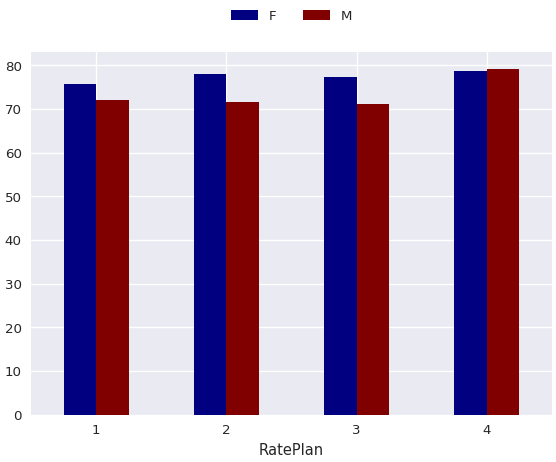

In [ ]:
from pixiedust.display import *
display(data)

### Step 6: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [11]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')
SI7 = StringIndexer(inputCol='IncomeGroup',outputCol='IncomeGroupEncoded')
SI8 = StringIndexer(inputCol='CallerType',outputCol='CallerTypeEncoded')
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", \
                                       "LongDistanceBilltypeEncoded", "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                      "Dropped","Usage","RatePlan","IncomeGroupEncoded","CallerTypeEncoded"], outputCol="features")

In [12]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,SI7,SI8,labelIndexer, assembler, rf, labelConverter])

In [13]:
# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: int, EstIncome: double, CarOwner: string, Age: double, International: double, Local: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: int, LongDistance: double, Dropped: int, IncomeGroup: string, CallerType: string, CHURN: string]

In [14]:
# Build models
model = pipeline.fit(train)

In [15]:
model.transform(test)

DataFrame[ID: int, Gender: string, Status: string, Children: int, EstIncome: double, CarOwner: string, Age: double, International: double, Local: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: int, LongDistance: double, Dropped: int, IncomeGroup: string, CallerType: string, CHURN: string, GenderEncoded: double, StatusEncoded: double, CarOwnerEncoded: double, PaymethodEncoded: double, LocalBilltypeEncoded: double, LongDistanceBilltypeEncoded: double, IncomeGroupEncoded: double, CallerTypeEncoded: double, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predictedLabel: string]

### Step 7: Score the test data set

In [16]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

ID CHURN  label predictedLabel  prediction  \
0  17     F    0.0              F         0.0   
1  21     F    0.0              F         0.0   
2  22     F    0.0              F         0.0   
3  23     F    0.0              F         0.0   
4  35     T    1.0              F         0.0   
5  42     F    0.0              F         0.0   

                                  probability  
0   [0.9339331148184045, 0.06606688518159555]  
1     [0.682740980324946, 0.3172590196750539]  
2   [0.8547667683888756, 0.14523323161112447]  
3  [0.9456843293842155, 0.054315670615784524]  
4    [0.6533630408673138, 0.3466369591326862]  
5   [0.8719117923132276, 0.12808820768677248]

### Step 8: Model Evaluation 

In [17]:
print 'Precision model1 = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count()))

Precision model1 = 0.92.


In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results))

Area under ROC curve = 0.92.


We have finished building and testing a predictive model. The next step is to deploy it for real time scoring. 

### Step 9: Save Model in ML repository

In [19]:
from dsx_ml.ml import save

model_name = "PrebuiltModel_TelcoChurn"
save(name = model_name,
     model = model,
     algorithm_type = 'Classification',
     test_data = test)

Using TensorFlow backend.


{'path': '/user-home/1001/DSX_Projects/DSX_Demos_el/models/PrebuiltModel_TelcoChurn/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python27/spark-2.0/DSX_Demos_el/PrebuiltModel_TelcoChurn/1'}

In [20]:
# Write the test data to a .csv so that we can later use it for Evaluation
writeCSV=test.toPandas()
writeCSV.to_csv('../datasets/TelcoModelEval_Prebuilt.csv', sep=',', index=False)

### Step 10: Test Saved Model with Test UI

1. Save the notebook and switch to the **Models** tab of the project (**hint**: right click the project name link, DSX_Lo, at the top, and open with another tab in your browser). 
2. Under **Models**, find and click into your saved model. 
4. Click the **Test** link to test the model. You can use the following data for testing: <br/>
`ID=99, Gender=M, Status=S, Children=0, Est Income=60000, Car Owner=Y, Age=34, LongDistance=68, International=50, Local=100, Dropped=0, Paymethod=CC, LocalBilltype=Budget, LongDistanceBilltype=Intnl_discount, Usage=334, RatePlan=3`

The results of the test is displayed as follows:<br/>
<img style="float: left;" src="https://github.com/yfphoon/dsx_local/blob/master/images/Test_Model.png?raw=true" alt="Test API" width=900 />

### Step 11:  Test model with a REST API call (Optional)

This step demonstrates an "internal REST API" call to test the model (for an unpublished model). Notice that we are using DSX variables for the model endpoint and token. See documentation for external REST call syntax. An exernal REST call will have a different end point and will require authentication. 

In [17]:
json_payload = [{
    "ID":999,
    "Gender":"F",
    "Status":"M",
    "Children":2.0,
    "EstIncome":77551.100000,
    "CarOwner":"Y",
    "Age":33.600000,
    "LongDistance":20.530000,
    "International":0.000000,
    "Local":41.890000,
    "Dropped":1.000000,
    "Paymethod":"CC",
    "LocalBilltype":"Budget",
    "LongDistanceBilltype":"Standard",
    "Usage":62.420000,
    "RatePlan":2.000000
}]

**Action Required**: Change the *scoring_endpoint* to the value that's shown as the *scoring_endpoint* afer running Save to ML repository function (see **Step 9**), for example *'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python27/spark-2.0/DSX_Local_Workshop_12/Telco_Churn_ML_model/1'*. 

In [18]:
import requests, json
from pprint import pprint

scoring_endpoint = 'https://dsxl-api/v3/project/score/Python27/spark-2.0/DSX_Local_Workshop_12/Telco_Churn_ML_model/1'

header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(scoring_endpoint, json=json_payload, headers=header_online)

response_dict = json.loads(response_scoring.content)
print("Prediction")

n = 1
for response in response_dict['object']['output']['predictions']:
    print("{}. {}".format(n,response))
    n+=1

Prediction


KeyError: 'output'

### Summary

You have finished working on this hands-on lab. In this notebook you created a model using SparkML API, deployed it in  Machine Learning service for online (real time) scoring and tested it using a test client. 


Created by **Sidney Phoon** and **Elena Lowery**
<br/>
yfphoon@us.ibm.com
elowery@us.ibm.com
<br/>
Jan 2, 2018